In [2]:
import nltk
from nltk.corpus import brown
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
import pycrfsuite
from itertools import chain
from collections import Counter

# Defining features of CRF model

Putting in features for each word, like ends with 'ly', 'ing', 'ed', etc. Or is it starting with capital letter and so on.

In [4]:
def word2features(sent, i):
    word = sent[i][0]
    features = [
        'bias',
        'word.lower=' + word.lower(),
        'word[-3:]=' + word[-3:],
        'word[-2:]=' + word[-2:],
        'word.isupper=%s' % word.isupper(),
        'word.istitle=%s' % word.istitle(),
        'word.isdigit=%s' % word.isdigit(),
    ]
    if i > 0:
        word1 = sent[i-1][0]
        features.extend([
            '-1:word.lower=' + word1.lower(),
            '-1:word.istitle=%s' % word1.istitle(),
            '-1:word.isupper=%s' % word1.isupper(),
        ])
    else:
        features.append('BOS')
        
    if i < len(sent)-1:
        word1 = sent[i+1][0]
        features.extend([
            '+1:word.lower=' + word1.lower(),
            '+1:word.istitle=%s' % word1.istitle(),
            '+1:word.isupper=%s' % word1.isupper(),
        ])
    else:
        features.append('EOS')
                
    return features


def sent2features(sent):
    return [word2features(sent, i) for i in range(len(sent))]

def sent2postags(sent):
    return [postag for token, postag in sent]

def sent2tokens(sent):
    return [token for token, postag in sent]    

# Load dataset

Load sentences and split into train and test sentences (<b>60-40 split currently, needs changes!</b>)

In [5]:
sent_dataset = brown.tagged_sents(tagset='universal')
train_sents, test_sents = train_test_split(sent_dataset, test_size=0.4, shuffle=True, random_state=100)
X_train = [sent2features(s) for s in train_sents]
y_train = [sent2postags(s) for s in train_sents]

X_test = [sent2features(s) for s in test_sents]
y_test = [sent2postags(s) for s in test_sents]

# Training

Creating `trainer` object and loading it with the feature data constructed above.

In [6]:
trainer = pycrfsuite.Trainer(verbose=False)

for xseq, yseq in zip(X_train, y_train):
    trainer.append(xseq, yseq)

trainer.set_params({
    'c1': 1.0,   # coefficient for L1 penalty
    'c2': 1e-3,  # coefficient for L2 penalty
    'max_iterations': 50,  # stop earlier

    # include transitions that are possible, but not observed
    'feature.possible_transitions': True
})

Train the model and save into 'browncorpus.crfsuite' file.

In [7]:
trainer.train('browncorpus.crfsuite')
trainer.logparser.last_iteration

{'num': 50,
 'scores': {},
 'loss': 66580.174147,
 'feature_norm': 241.602197,
 'error_norm': 5043.937762,
 'active_features': 20190,
 'linesearch_trials': 1,
 'linesearch_step': 1.0,
 'time': 0.882}

# Inference

Example sentence tagging.

In [8]:
tagger = pycrfsuite.Tagger()
tagger.open('browncorpus.crfsuite')
example_sent = test_sents[345]
print(' '.join(sent2tokens(example_sent)), end='\n\n')

print("Predicted:", ' '.join(tagger.tag(sent2features(example_sent))))
print("Correct:  ", ' '.join(sent2postags(example_sent)))

The Manchester Guardian wondered how anyone in a railway carriage would have an opportunity to talk to Mr. Lewis , since it was well known that Mr. Lewis always did all of the talking .

Predicted: DET NOUN NOUN VERB ADV NOUN ADP DET NOUN NOUN VERB VERB DET NOUN PRT VERB ADP NOUN NOUN . ADP PRON VERB ADV VERB ADP NOUN NOUN ADV VERB PRT ADP DET VERB .
Correct:   DET NOUN NOUN VERB ADV NOUN ADP DET NOUN NOUN VERB VERB DET NOUN PRT VERB ADP NOUN NOUN . ADP PRON VERB ADV VERB ADP NOUN NOUN ADV VERB PRT ADP DET VERB .


# Evaluation

Calculate precision, recall and f1-score tagwise.

In [9]:
def get_classification_report(y_true, y_pred):
    lb = LabelBinarizer()
    y_true_combined = lb.fit_transform(list(chain.from_iterable(y_true)))
    y_pred_combined = lb.transform(list(chain.from_iterable(y_pred)))

    tagset = lb.classes_
    return classification_report(
        y_true_combined,
        y_pred_combined,
        labels = range(len(tagset)),
        target_names = tagset,
    )


## Test set evaluation

In [10]:
y_pred = [tagger.tag(xseq) for xseq in X_test]

In [11]:
print(get_classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           .       1.00      1.00      1.00     59144
         ADJ       0.94      0.90      0.92     33448
         ADP       0.98      0.98      0.98     58138
         ADV       0.93      0.94      0.93     22620
        CONJ       0.99      1.00      1.00     15153
         DET       0.99      1.00      0.99     55068
        NOUN       0.97      0.97      0.97    110169
         NUM       0.97      0.97      0.97      5881
        PRON       0.99      0.99      0.99     19772
         PRT       0.93      0.94      0.94     11815
        VERB       0.97      0.97      0.97     73106
           X       0.79      0.35      0.48       605

   micro avg       0.97      0.97      0.97    464919
   macro avg       0.95      0.92      0.93    464919
weighted avg       0.97      0.97      0.97    464919
 samples avg       0.97      0.97      0.97    464919



## Confusion matrix

In [56]:
y_true_combined = list(chain.from_iterable(y_test))
y_pred_combined = list(chain.from_iterable(y_pred))

tags_of_interest = ['NOUN','ADJ','ADP',]
import pandas as pd
df = pd.DataFrame(
    confusion_matrix(y_true_combined, y_pred_combined, labels=tags_of_interest),
    columns=tags_of_interest,
    index=tags_of_interest
)
df

,NOUN,ADJ,ADP
NOUN,107356,1272,16
ADJ,1498,30210,24
ADP,55,20,56806


# From class methods

In [1]:
from CRFTagger import CRFTagger

crf_tagger = CRFTagger('scratch', from_saved=True)
crf_tagger.tag("Moses shed crocodile tears when he heard of the volcano.")


2024-09-28 23:27:26,420 [INFO] CRFTagger - Fetching saved scratch.crfsuite


['NOUN',
 'VERB',
 'ADJ',
 'NOUN',
 'ADV',
 'PRON',
 'VERB',
 'ADP',
 'DET',
 'NOUN',
 '.']

## 5-fold cross validation

In [2]:
from sklearn.model_selection import KFold
import numpy as np
import pandas as pd
all_sents = np.array(crf_tagger.sent_dataset, dtype=object)
K=5
k_fold = KFold(K, shuffle=True, random_state=231)
df_l =[]
for train_sents_idx, test_sents_idx in k_fold.split(all_sents):
    df_l.append(pd.DataFrame(
    CRFTagger.test_tagger('crf_k', all_sents[train_sents_idx], all_sents[test_sents_idx]),
    ).T)
result_df = pd.DataFrame(data=np.mean([tt.to_numpy()[:,:-1] for tt in df_l], axis=0), columns=df_l[0].columns[:-1], index=df_l[0].index)
result_df


2024-09-28 23:27:26,671 [INFO] numexpr.utils - Note: NumExpr detected 16 cores but "NUMEXPR_MAX_THREADS" not set, so enforcing safe limit of 8.

2024-09-28 23:27:26,671 [INFO] numexpr.utils - NumExpr defaulting to 8 threads.

2024-09-28 23:27:37,159 [INFO] CRFTagger - Test crf training

2024-09-28 23:28:14,306 [INFO] CRFTagger - Returning results

2024-09-28 23:28:23,316 [INFO] CRFTagger - Test crf training

2024-09-28 23:28:56,742 [INFO] CRFTagger - Returning results

2024-09-28 23:29:04,732 [INFO] CRFTagger - Test crf training

2024-09-28 23:29:38,744 [INFO] CRFTagger - Returning results

2024-09-28 23:29:46,753 [INFO] CRFTagger - Test crf training

2024-09-28 23:30:19,858 [INFO] CRFTagger - Returning results

2024-09-28 23:30:27,896 [INFO] CRFTagger - Test crf training

2024-09-28 23:30:59,579 [INFO] CRFTagger - Returning results


,precision,recall,f1-score
.,0.999722,0.999932,0.999827
ADJ,0.936941,0.912558,0.924579
ADP,0.977484,0.982902,0.980184
ADV,0.947225,0.929464,0.938243
CONJ,0.994014,0.997028,0.995518
DET,0.994103,0.994848,0.994475
NOUN,0.967736,0.976948,0.972319
NUM,0.972956,0.967415,0.970169
PRON,0.991678,0.987939,0.989804
PRT,0.942121,0.940127,0.941107



Caching the list of root modules, please wait!
(This will only be done once - type '%rehashx' to reset cache!)



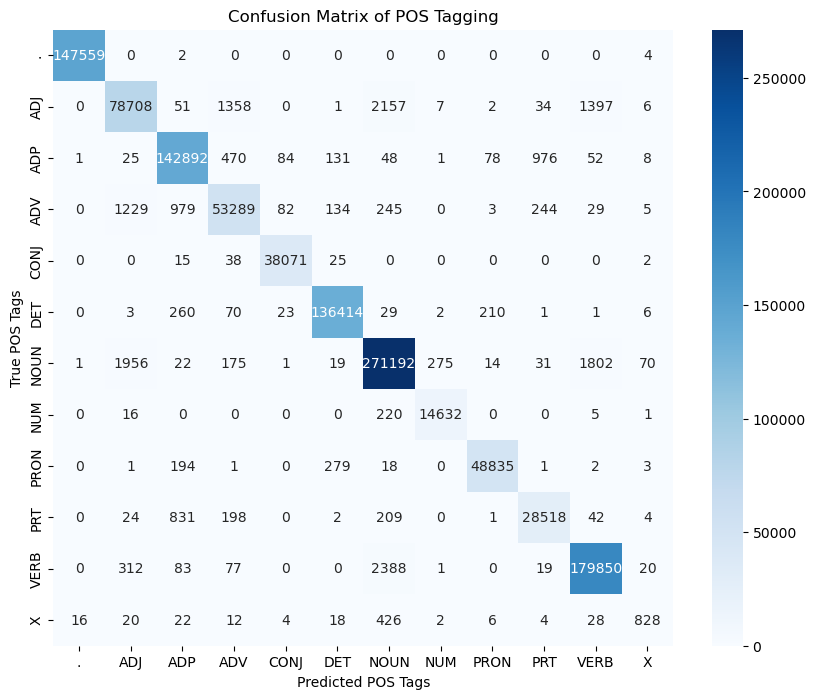

In [3]:
from sklearn.metrics import confusion_matrix
from itertools import chain
X_all = [[word for word, _ in sent] for sent in all_sents]
y_true = [[tag for _, tag in sent] for sent in all_sents]
y_pred = [crf_tagger.tag(sent) for sent in X_all]
pos_tags = ['.','ADJ','ADP','ADV','CONJ','DET','NOUN','NUM','PRON','PRT','VERB','X']
y_true_combined = list(chain.from_iterable(y_true))
y_pred_combined = list(chain.from_iterable(y_pred))

cmatrix = confusion_matrix(y_true_combined, y_pred_combined, labels=pos_tags)

import matplotlib.pyplot as plt
import seaborn as sns
plt.figure(figsize=(10, 8))
sns.heatmap(cmatrix, annot=True, fmt='d', cmap='Blues', xticklabels=pos_tags, yticklabels=pos_tags)

plt.xlabel('Predicted POS Tags')
plt.ylabel('True POS Tags')
plt.title('Confusion Matrix of POS Tagging')
plt.show()


In [4]:
import pickle
with open('crf_results.pkl', 'wb') as f:
    pickle.dump(result_df,f)